### This script is used to find the best hyperparameter combination using Grid Search 
### by training the model over all feature
The test result of the model with the the best hyperparameter combination will then be used to compare with the model that is trained on selected features chosen by GA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from utilities import import_data
from utilities import set_seed
from casper_test import final_test
from casper_test import rkf_validator
from sklearn.model_selection import train_test_split

In [2]:
# select training device
device = "cpu"
    
# make results determinstic
seed = 4660
if seed != None:
    set_seed(seed)
    
# Define hyperparameter candidates
# hyperparameters = {'max_hidden_neurons': 5,
#                    'P': 1,
#                    'D': 0.005,
#                    'lrs': [0.2, 0.005, 0.001]}

hyperparameters_candidates = {'max_hidden_neurons': [1, 5, 10, 15],
                   'P': [0.1, 1, 5, 10],
                   'D': [0, 0.005, 0.05],
                   'lrs': [[0.5, 0.01, 0.005], [0.2, 0.005, 0.001], [0.05, 0.01, 0.0005]]}

# hyperparameters_candidates = {'max_hidden_neurons': [1, 5],
#                    'P': [1, 2],
#                    'D': [0.005],
#                    'lrs': [[0.05, 0.01, 0.0005]]}

# import data
data, _, _ = import_data()
train_data, test_data, _, _ = train_test_split(data, data.iloc[:,0], test_size=0.2, random_state=seed)

n_splits = 10
n_repeats = 4

In [3]:
scores = []
hyperparameter_combinations = []

In [4]:
def grid_search(data, hyperparameters_candidates, n_splits, n_repeats, device='cpu'):
    print(f"Sample Size: {data.shape[0]}")
    start_time = time.time()
    num_of_combinations = (len(hyperparameters_candidates['max_hidden_neurons']) * 
                           len(hyperparameters_candidates['P']) * 
                           len(hyperparameters_candidates['D']) * 
                           len(hyperparameters_candidates['lrs'])) 
    count = 1
    for max_hidden_neurons in hyperparameters_candidates['max_hidden_neurons']:
        for P in hyperparameters_candidates['P']:
            for D in hyperparameters_candidates['D']:
                for lrs in hyperparameters_candidates['lrs']:
                    hyperparameters = {'max_hidden_neurons': max_hidden_neurons,
                                       'P': P,
                                       'D': D,
                                       'lrs': lrs}
                    score = rkf_validator(data, hyperparameters, n_splits, n_repeats, device=device, fast_mode=True, verbose=False)
                    print(f"Searched Hyperparameter Combination: {count}/{num_of_combinations}   MSE: {score}", end = '\r')
                    scores.append(score)
                    hyperparameter_combinations.append(hyperparameters)
                    count += 1
    print(f"Grid Search Finished, Spent: {time.time() - start_time}s")

In [5]:
# Grid Search
grid_search(train_data, hyperparameters_candidates, n_splits, n_repeats, device='cpu')

Sample Size: 208
Grid Search Finished, Spent: 4614.587333917618sMSE: 6.2858241379261015


In [6]:
# Save all hyperparameter combinations
with open('results/grid_search_no_GA.pkl', 'wb') as fp:
    pickle.dump(hyperparameter_combinations, fp)
with open('results/grid_search_no_GA.pkl', 'rb') as fp:
    hyperparameter_combinations = pickle.load(fp)
    
# Save all scores corresponding to different hyperparameter combinations
with open('results/grid_search_no_GA.npy', 'wb') as f:
    np.save(f, scores)
with open('results/grid_search_no_GA.npy', 'rb') as f:
    scores = np.load(f)

best_hyperparameters = hyperparameter_combinations[np.argmin(scores)]
print(f"best score: {np.min(scores)}")
print(f"best hyperparameters: {best_hyperparameters}")

best score: 2.1467908173799515
best hyperparameters: {'max_hidden_neurons': 1, 'P': 0.1, 'D': 0.005, 'lrs': [0.5, 0.01, 0.005]}


Model is trained 200 times
with each run has different test-training split and initialised weights
Mean: 1.990778547525405845    MAE: 1.0157
Median: 1.971004605293274
Standard Deviation: 0.4667938147352776

Mean: 1.1400315463542938
Median: 1.1284971237182617
Standard Deviation: 0.14405707630210013


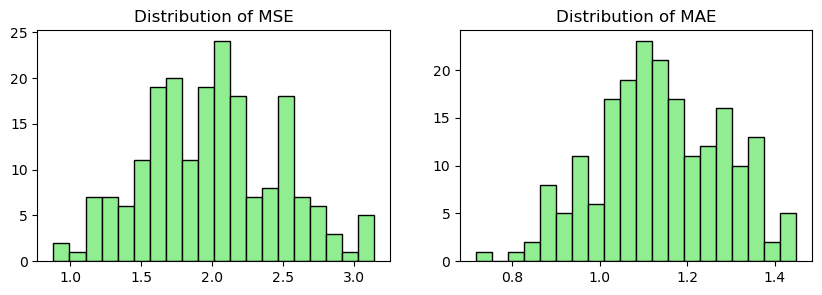

Class 1
Number of runs that contain MSE/MAE for this class: 37
MSE: average over all 37 runs: 14.6079
MSE: median over all 37 runs: 14.4213
MSE: std over all 37 runs: 2.6181
L1E: average of MAE over all 37 runs: 3.8035
L1E: median over all 37 runs: 3.7789
L1E std over all 37 runs: 0.3444

Class 2
Number of runs that contain MSE/MAE for this class: 163
MSE: average over all 163 runs: 7.6656
MSE: median over all 163 runs: 7.4361
MSE: std over all 163 runs: 2.4544
L1E: average of MAE over all 163 runs: 2.7180
L1E: median over all 163 runs: 2.6992
L1E std over all 163 runs: 0.4423

Class 3
Number of runs that contain MSE/MAE for this class: 197
MSE: average over all 197 runs: 3.4947
MSE: median over all 197 runs: 3.3928
MSE: std over all 197 runs: 1.1979
L1E: average of MAE over all 197 runs: 1.7882
L1E: median over all 197 runs: 1.7969
L1E std over all 197 runs: 0.3286

Class 4
Number of runs that contain MSE/MAE for this class: 199
MSE: average over all 199 runs: 0.8749
MSE: median over 

In [7]:
final_test(data, best_hyperparameters, 10, 20, device=device)

### P test to compare model w/wo oversampling

In [11]:
import scipy.stats as stats
best_hyper = {'max_hidden_neurons': 1, 'P': 0.1, 'D': 0.005, 'lrs': [0.5, 0.01, 0.005]}
best_hyper_oversampling = {'max_hidden_neurons': 1, 'P': 5, 'D': 0.05, 'lrs': [0.5, 0.01, 0.005]}

In [13]:
MSEs, _, _, _, _ = rkf_validator(data, best_hyper, n_splits, n_repeats, device=device, fast_mode=False, verbose=False)

In [14]:
MSEs_oversampling, _, _, _, _ = rkf_validator(data, best_hyper, n_splits, n_repeats, device=device, fast_mode=False, verbose=False, oversampling=True)

In [17]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(MSEs, MSEs_oversampling)

# Print the t-statistic and p-value
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -8.748018236433223
P-value: 3.3277583426773586e-13


P value is very small, the model without oversampling performs better